# Laboratorio 4

## Task 1

1. ¿Cómo afecta la elección de la estrategia de exploración (exploring starts vs soft policy) a la precisión de la
evaluación de políticas en los métodos de Monte Carlo?
a. Considere la posibilidad de comparar el desempeño de las políticas evaluadas con y sin explorar
los inicios o con diferentes niveles de exploración en políticas blandas.  

La técnica de exploring starts implica iniciar cada episodio desde un estado y una acción seleccionados aleatoriamente, lo que hace que todas las acciones y estados sean explorados, esto a lo que ayuda es a reducir el sesgo en las estimaciones del valor y mejora la precisión de la política evaluado al asegurarse de tener una cobertura completa del espacio de estados y acciones, por otro lado una estrategia soft policy implica seleccionar acciones basadas en una distribución probabilística, como una estrategia e-greedy , se puede mencionar que la precisión con esta puede variar según la el nivel de exploración que se realice una política con un 𝜖 alto proporcionan una mejor exploración lo que hace que los resultados sean mas precisos en un periodo de tiempo largo.


2. En el contexto del aprendizaje de Monte Carlo fuera de la póliza, ¿cómo afecta la razón de muestreo de
importancia a la convergencia de la evaluación de políticas? Explore cómo la razón de muestreo de
importancia afecta la estabilidad y la convergencia. 


En el contexto del aprendizaje de Monte Carlo fuera de la póliza, la razón de muestreo es importante para la convergencia de la evaluación de la política esto debido a que esto corrige el sesgo introducido al evaluar una nueva pólice, sin embargo una muestra alta puede causar una alta varianza, que afecta negativamente la estabilidad y como es que converge el modelo, por lo contrario si está bien ajustada causaría los efectos contrarios.


3. ¿Cómo puede el uso de una soft policy influir en la eficacia del aprendizaje de políticas óptimas en
comparación con las políticas deterministas en los métodos de Monte Carlo? Compare el desempeño y los
resultados de aprendizaje de las políticas derivadas de estrategias épsilon-greedy con las derivadas de
políticas deterministas.  

El uso de soft policy puede influir en la eficacia del aprendizaje de políticas optima en comparación con políticas deterministas en los métodos de monte carlo, se puede mencionar que las políticas e-greedy facilitan una mejor exploración del espacio de estados, permitiendo que se puede identificar las políticas optimas que pueden que no se cubran con las políticas deterministas, estas políticas balacean la exploración y explotación, lo que hace que la convergencia sea más robusta a lo largo del plazo, en comparación de las políticas derivadas de e-greedy tienen a adaptarse y pueden evitar caer en óptimos locales, otro punto importante es que las políticas deterministas limitan la exploración a las mejores acciones conocidas, lo que hace que sea eficiente a corto plazo pero con un gran riesgo a lo largo del tiempo, ya que puede ser que caiga en subóptimos locales.


4. ¿Cuáles son los posibles beneficios y desventajas de utilizar métodos de Monte Carlo off-policy en
comparación con los on-policy en términos de eficiencia de la muestra, costo computacional. y velocidad
de aprendizaje?  

## Task 2

In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict

In [2]:
# Definicion de ambiente
class InventoryEnvironment:
    def __init__(self):
        self.products = ['product_A', 'product_B']
        self.max_stock = 10  # Pueden cambiar este número si gustan
        self.demand = {'product_A': [0, 1, 2], 'product_B': [0, 1, 2]}
        self.restock_cost = {'product_A': 5, 'product_B': 7}
        self.sell_price = {'product_A': 10, 'product_B': 15}
        self.state = None

    def reset(self):
        self.state = {product: random.randint(0, self.max_stock) for product in self.products}
        return self.state

    def step(self, action):
        reward = 0
        for product in self.products:
            stock = self.state[product]
            restock = action[product]
            self.state[product] = min(self.max_stock, stock + restock)
            demand = random.choice(self.demand[product])
            sales = min(demand, self.state[product])
            self.state[product] -= sales
            reward += sales * self.sell_price[product] - restock * self.restock_cost[product]
        return self.state, reward

# Init el ambiente
env = InventoryEnvironment()

In [3]:
def epsilon_greedy_policy(state, epsilon=0.1):
    if random.random() < epsilon:
        return {product: random.randint(0, 2) for product in state.keys()}
    else:
        return {product: 1 for product in state.keys()}

# Política de comportamiento (diferente de la política objetivo)
def behavior_policy(state):
    return {product: random.randint(0, 2) for product in state.keys()}

# Generar estados y acciones iniciales diversos
def generate_diverse_starts(num_starts, max_stock):
    diverse_starts = []
    for _ in range(num_starts):
        state = {product: random.randint(0, max_stock) for product in env.products}
        action = {product: random.randint(0, 2) for product in env.products}
        diverse_starts.append((state, action))
    return diverse_starts

num_episodes = 10
num_days = 30
epsilon = 0.1

# Generar estados y acciones iniciales diversos
diverse_starts = generate_diverse_starts(num_episodes, env.max_stock)

all_rewards = []
off_policy_rewards = []

for episode in range(num_episodes):
    start_state, start_action = diverse_starts[episode]
    state = env.reset()
    episode_rewards = []
    episode_off_policy_rewards = []
    
    # Primer paso con acción inicial diversa
    state, reward = env.step(start_action)
    episode_rewards.append(reward)
    
    # Evaluación off-policy
    target_action = epsilon_greedy_policy(state, epsilon)
    _, target_reward = env.step(target_action)
    episode_off_policy_rewards.append(target_reward)
    
    # Pasos subsecuentes siguiendo la política de comportamiento
    for day in range(1, num_days):
        action = behavior_policy(state)
        state, reward = env.step(action)
        episode_rewards.append(reward)
        target_action = epsilon_greedy_policy(state, epsilon)
        _, target_reward = env.step(target_action)
        episode_off_policy_rewards.append(target_reward)
    
    all_rewards.append(episode_rewards)
    off_policy_rewards.append(episode_off_policy_rewards)

# Convertir los resultados en un DataFrame de Pandas para análisis
rewards_df = pd.DataFrame(all_rewards)
rewards_df.columns = [f'Day_{i+1}' for i in range(num_days)]
rewards_df.index = [f'Episode_{i+1}' for i in range(num_episodes)]

off_policy_rewards_df = pd.DataFrame(off_policy_rewards)
off_policy_rewards_df.columns = [f'Day_{i+1}' for i in range(num_days)]
off_policy_rewards_df.index = [f'Episode_{i+1}' for i in range(num_episodes)]

# Mostrar los DataFrames
print("Recompensas con Política de Comportamiento:")
print(rewards_df)

print("\nRecompensas Evaluadas con Política Objetivo (Off-Policy):")
print(off_policy_rewards_df)

Recompensas con Política de Comportamiento:
            Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  Day_7  Day_8  Day_9  \
Episode_1      -7     15     20     25     23     13     21     11     -7   
Episode_2      15     18     18     11     15      1      8     -2     11   
Episode_3      18     30      5    -19     35     30     -5     36     40   
Episode_4       6      1     -4     15     13     15     30     10     10   
Episode_5      -2     16      0      3     30      6     13      0      0   
Episode_6       6    -24     28     -9     30     10     18     -4      6   
Episode_7       6     28    -19    -17      1     31    -24     13     33   
Episode_8      -2      3    -14      6     16     10     28      1     -9   
Episode_9       8      3     20     15     -4     28      1     10      1   
Episode_10     23     21    -14     30     -9     10      8    -19     26   

            Day_10  ...  Day_21  Day_22  Day_23  Day_24  Day_25  Day_26  \
Episode_1       35  ...      11  

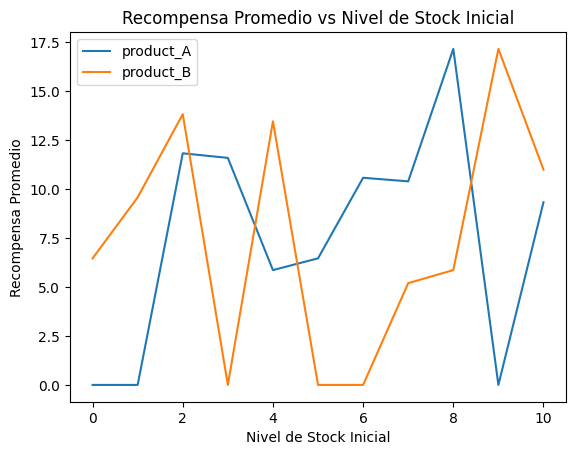

In [4]:
import matplotlib.pyplot as plt

# Calcular la recompensa promedio para diferentes niveles de stock iniciales
stock_levels = range(env.max_stock + 1)
average_rewards = {product: [] for product in env.products}

for product in env.products:
    for level in stock_levels:
        level_rewards = []
        for episode in all_rewards:
            initial_stock = diverse_starts[all_rewards.index(episode)][0][product]
            if initial_stock == level:
                level_rewards.append(np.mean(episode))
        average_rewards[product].append(np.mean(level_rewards) if level_rewards else 0)

# Graficar las recompensas promedio para diferentes niveles de stock iniciales
for product in env.products:
    plt.plot(stock_levels, average_rewards[product], label=product)

plt.xlabel('Nivel de Stock Inicial')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio vs Nivel de Stock Inicial')
plt.legend()
plt.show()


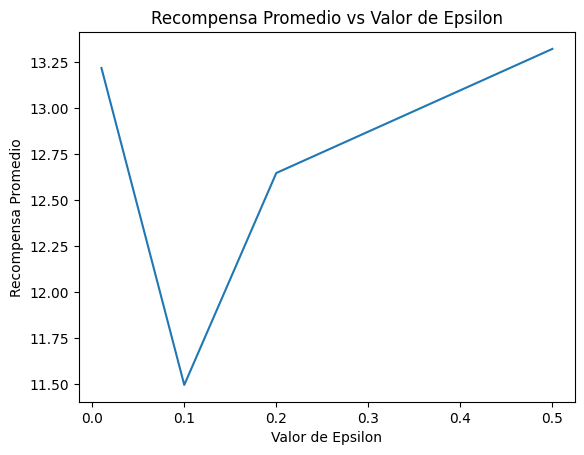

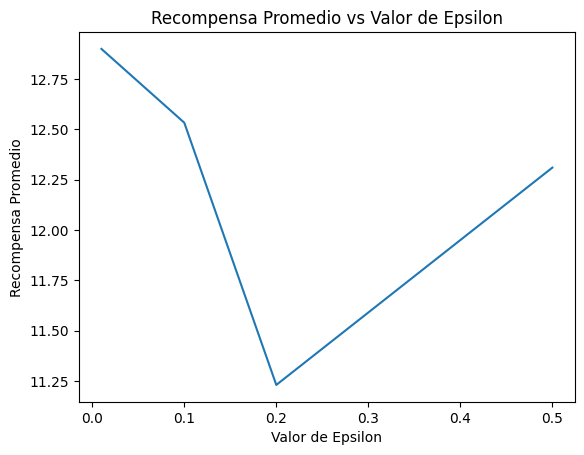

In [5]:
epsilons = [0.01, 0.1, 0.2, 0.5]
epsilon_rewards = {epsilon: [] for epsilon in epsilons}

for epsilon in epsilons:
    for episode in range(num_episodes):
        start_state, start_action = diverse_starts[episode]
        state = env.reset()
        episode_rewards = []
        
        # Primer paso con acción inicial diversa
        state, reward = env.step(start_action)
        episode_rewards.append(reward)
        
        # Pasos subsecuentes siguiendo la política epsilon-greedy
        for day in range(1, num_days):
            action = epsilon_greedy_policy(state, epsilon)
            state, reward = env.step(action)
            episode_rewards.append(reward)
        
        epsilon_rewards[epsilon].append(np.mean(episode_rewards))

# Graficar las recompensas promedio para diferentes valores de epsilon
average_epsilon_rewards = {epsilon: np.mean(rewards) for epsilon, rewards in epsilon_rewards.items()}
plt.plot(list(average_epsilon_rewards.keys()), list(average_epsilon_rewards.values()))
plt.xlabel('Valor de Epsilon')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio vs Valor de Epsilon')
plt.show()
epsilons = [0.01, 0.1, 0.2, 0.5]
epsilon_rewards = {epsilon: [] for epsilon in epsilons}

for epsilon in epsilons:
    for episode in range(num_episodes):
        start_state, start_action = diverse_starts[episode]
        state = env.reset()
        episode_rewards = []
        
        # Primer paso con acción inicial diversa
        state, reward = env.step(start_action)
        episode_rewards.append(reward)
        
        # Pasos subsecuentes siguiendo la política epsilon-greedy
        for day in range(1, num_days):
            action = epsilon_greedy_policy(state, epsilon)
            state, reward = env.step(action)
            episode_rewards.append(reward)
        
        epsilon_rewards[epsilon].append(np.mean(episode_rewards))

# Graficar las recompensas promedio para diferentes valores de epsilon
average_epsilon_rewards = {epsilon: np.mean(rewards) for epsilon, rewards in epsilon_rewards.items()}
plt.plot(list(average_epsilon_rewards.keys()), list(average_epsilon_rewards.values()))
plt.xlabel('Valor de Epsilon')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio vs Valor de Epsilon')
plt.show()

In [6]:
# Calcular la recompensa promedio para on-policy y off-policy
average_on_policy_rewards = rewards_df.mean().mean()
average_off_policy_rewards = off_policy_rewards_df.mean().mean()

print(f'Recompensa Promedio On-Policy: {average_on_policy_rewards}')
print(f'Recompensa Promedio Off-Policy: {average_off_policy_rewards}')


Recompensa Promedio On-Policy: 10.316666666666665
Recompensa Promedio Off-Policy: 13.313333333333333
